In [1]:
from IPython.display import clear_output
from copy import deepcopy

In [2]:
! pip install /kaggle/input/psimage/psimage-0.1.5-py3-none-any.whl
clear_output()

In [45]:
from pathlib import Path
from psimage import PSImage
from PIL import Image
from psimage.base.anno_visualizer import AnnoDescription
import numpy as np
import matplotlib.pyplot as plt
import json
import inspect
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torchvision.io import read_image
from torch.utils.data import DataLoader
import os
from tqdm import tqdm
from time import time
import sys
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


layer 1, image size: (43875, 59760)
layer 2, image size: (21937, 29880)
layer 4, image size: (10968, 14940)
layer 8, image size: (5484, 7470)
layer 16, image size: (2742, 3735)
layer 32, image size: (1371, 1867)
layer 64, image size: (685, 933)
layer 128, image size: (342, 466)
GEN RANDOM ARGS :: (patch_size: int, stride: int = None, layer: int = 1, region: numpy.ndarray = None, region_intersection: float = 0.75) -> Iterator[psimage.patches.Patch]
GEN DENSE ARGS :: (layer: int, tl: tuple[int, int], br: tuple[int, int]) -> numpy.ndarray


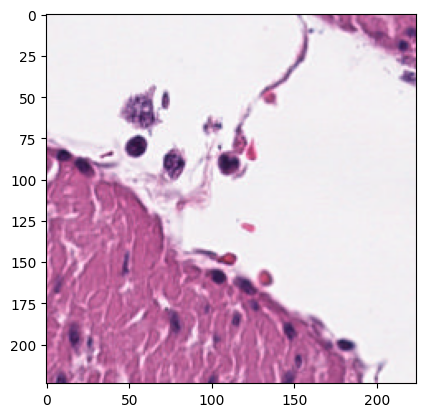

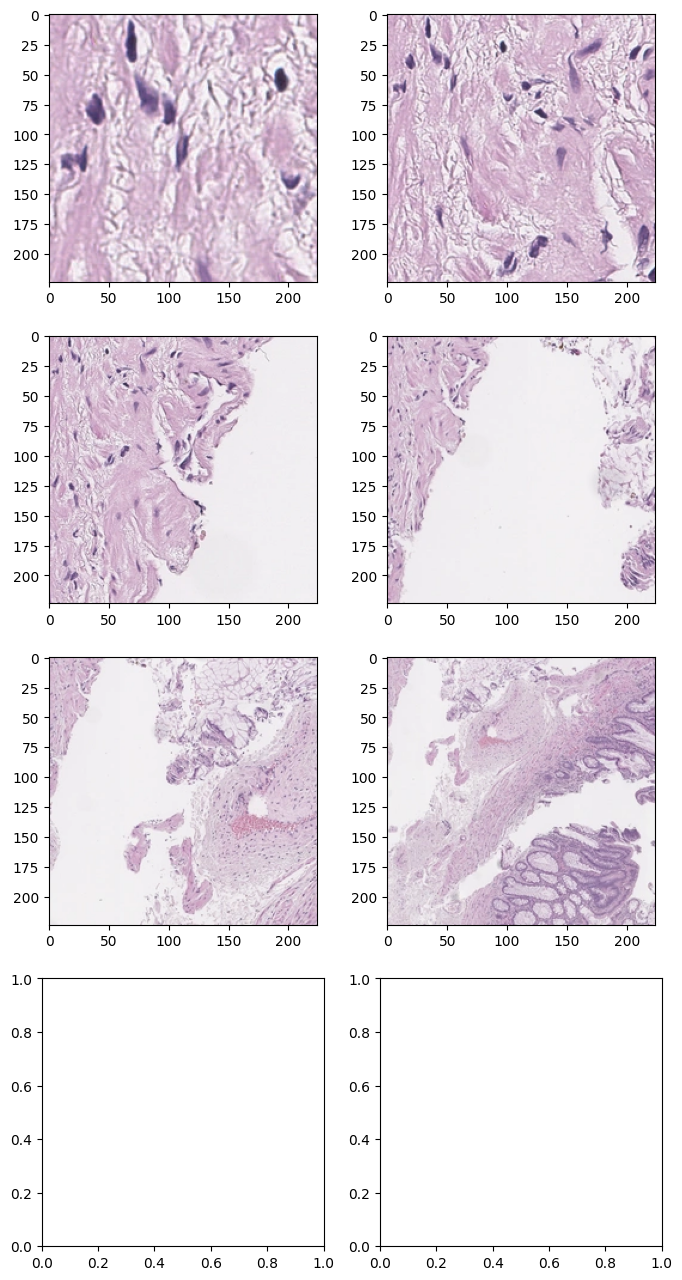

In [33]:
p = Path("/kaggle/input/wss1-v1-psi/WSS1_v1_psi/train/train_02.psi")
with PSImage(p) as psim:
    # -- get resolution of each layer
    print()
    for layer in psim.layout.layers:
        size = psim.layer_size(layer)
        print(f"layer {layer}, image size: {size}")
    roi = psim.get_region((0, 0), (40350, 31872), (800, 600))
    plt.imshow(Image.open('/kaggle/input/nct-crc-he-100k/NCT-CRC-HE-100K/MUS/MUS-AAEMWDQI.tif'))
    print(f"GEN RANDOM ARGS :: {inspect.signature(psim.patch_gen_dense)}")
    print(f"GEN DENSE ARGS :: {inspect.signature(psim.get_region_from_layer)}")
    fig, axes = plt.subplots(4, 2, figsize=(8, 16))
    for i in range(0, 6):
        axes[i // 2][i % 2].imshow(psim.get_region_from_layer(2 ** i, (30000 // (2 ** i) , 15000 // (2 ** i)), (30000 // (2 ** i) +224 , 15000 // (2 ** i) + 224)))
    # plt.imshow(roi)

In [ ]:
! mkdir /kaggle/working/random_patches
! mkdir /kaggle/working/dense_patches
ds_path = Path("/kaggle/input/wss1-v1-psi/WSS1_v1_psi/train")
out_path_rnd = Path("/kaggle/working/random_patches")
out_path_dense = Path("/kaggle/working/dense_patches")
psim = PSImage(ds_path / "train_01.psi")
anno_json = open(ds_path / "train_01_anno.json")

for k, anno in enumerate(json.load(anno_json)):
    anno_cls = anno["class"]
    anno_polygon = np.array(anno["vertices"], dtype=np.float64)
    print(f"processing region {k + 1} ({anno_cls})")

    # example of random patch extraction from each annotated region
    for i, patch in enumerate(
        psim.patch_gen_random(224, region=anno_polygon, n_patches=100)
    ):
        print(patch)
        tl, br = (patch.pos_y, patch.pos_x), (patch.pos_y + 224, patch.pos_x + 224)
        roi = psim.get_region_from_layer(patch.layer, tl, br)
        print(tl, br)
        figure, axes = plt.subplots(1, 2, figsize=(10, 10))
        axes[0].imshow(patch.to_image())
        axes[1].imshow(roi)
        # patch_name = f"{k+1}_{anno_cls}_{i+1}.jpg"
        # patch.to_image().save(out_path_rnd / patch_name)
        break
    break
    # example of dense patch extraction from each annotated region
    for i, patch in enumerate(
        psim.patch_gen_dense(224, stride=112, region=anno_polygon)
    ):
        patch_name = f"{k+1}_{anno_cls}_{i+1}.jpg"
        patch.to_image().save(out_path_dense / patch_name)

print("All patches extracted.")
anno_json.close()
psim.close()

In [32]:
class PsimageDataset(Dataset):
    
    def __init__(self, img_dir, anno_json, layer=1, transform=None, target_transform=None):
        super().__init__()
        self.layer = layer
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.labels = {}
        self.psim = PSImage(img_dir)
        anno_json = open(anno_json)
        for anno in tqdm(json.load(anno_json)):
            anno_cls = anno["class"]
            if anno_cls not in self.labels.keys():
                self.labels[anno_cls] = []
            anno_polygon = np.array(anno["vertices"], dtype=np.float64)
            try:
                for patch in self.psim.patch_gen_dense(224, stride=224, layer=layer, region=anno_polygon, region_intersection=0.95):
                    tl, br = (patch.pos_y, patch.pos_x), (patch.pos_y + 224, patch.pos_x + 224)
                    self.labels[anno_cls].append((tl, br))
            except PSImageException:
                pass
        anno_json.close()
                
    def get_structure(self):
        count = 0
        structure = []
        for key in self.labels.keys():
            count += len(self.labels[key])
            structure.append(count)
        return structure
        
    def __len__(self):
        return sum([len(self.labels[label]) for label in self.labels.keys()])

    def __getitem__(self, idx):
        totensor = torchvision.transforms.ToTensor()
        count = 0
        for key in self.labels.keys():
            if count + len(self.labels[key]) > idx:
                label = key
                break
            count += len(self.labels[key])
        tl, br = self.labels[label][idx - count]
        image = totensor(self.psim.get_region_from_layer(self.layer, tl, br)).to(DEVICE)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [4]:
class SupConLoss(nn.Module):
    """Supervised Contrastive Learning: https://arxiv.org/pdf/2004.11362.pdf.
    It also supports the unsupervised contrastive loss in SimCLR"""
    def __init__(self, temperature=0.07, contrast_mode='all',
                 base_temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature
        self.contrast_mode = contrast_mode
        self.base_temperature = base_temperature

    def forward(self, features, labels=None, mask=None):
        """Compute loss for model. If both `labels` and `mask` are None,
        it degenerates to SimCLR unsupervised loss:
        https://arxiv.org/pdf/2002.05709.pdf

        Args:
            features: hidden vector of shape [bsz, n_views, ...].
            labels: ground truth of shape [bsz].
            mask: contrastive mask of shape [bsz, bsz], mask_{i,j}=1 if sample j
                has the same class as sample i. Can be asymmetric.
        Returns:
            A loss scalar.
        """
        device = (torch.device('cuda')
                  if features.is_cuda
                  else torch.device('cpu'))

        if len(features.shape) < 3:
            raise ValueError('`features` needs to be [bsz, n_views, ...],'
                             'at least 3 dimensions are required')
        if len(features.shape) > 3:
            features = features.view(features.shape[0], features.shape[1], -1)

        batch_size = features.shape[0]
        if labels is not None and mask is not None:
            raise ValueError('Cannot define both `labels` and `mask`')
        elif labels is None and mask is None:
            mask = torch.eye(batch_size, dtype=torch.float32).to(device)
        elif labels is not None:
            labels = labels.contiguous().view(-1, 1)
            if labels.shape[0] != batch_size:
                raise ValueError('Num of labels does not match num of features')
            mask = torch.eq(labels, labels.T).float().to(device)
        else:
            mask = mask.float().to(device)

        contrast_count = features.shape[1]
        contrast_feature = torch.cat(torch.unbind(features, dim=1), dim=0)
        if self.contrast_mode == 'one':
            anchor_feature = features[:, 0]
            anchor_count = 1
        elif self.contrast_mode == 'all':
            anchor_feature = contrast_feature
            anchor_count = contrast_count
        else:
            raise ValueError('Unknown mode: {}'.format(self.contrast_mode))

        # compute logits
        anchor_dot_contrast = torch.div(
            torch.matmul(anchor_feature, contrast_feature.T),
            self.temperature)
        # for numerical stability
        logits_max, _ = torch.max(anchor_dot_contrast, dim=1, keepdim=True)
        logits = anchor_dot_contrast - logits_max.detach()

        # tile mask
        mask = mask.repeat(anchor_count, contrast_count)
        # mask-out self-contrast cases
        logits_mask = torch.scatter(
            torch.ones_like(mask),
            1,
            torch.arange(batch_size * anchor_count).view(-1, 1).to(device),
            0
        )
        mask = mask * logits_mask

        # compute log_prob
        exp_logits = torch.exp(logits) * logits_mask
        log_prob = logits - torch.log(exp_logits.sum(1, keepdim=True))

        # compute mean of log-likelihood over positive
        mean_log_prob_pos = (mask * log_prob).sum(1) / mask.sum(1)

        # loss
        loss = - (self.temperature / self.base_temperature) * mean_log_prob_pos
        loss = loss.view(anchor_count, batch_size).mean()

        return loss

In [5]:
from torch.optim import Optimizer
from tensorboardX import SummaryWriter

class Lamb(Optimizer):
    r"""Implements Lamb algorithm.

    It has been proposed in `Large Batch Optimization for Deep Learning: Training BERT in 76 minutes`_.

    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        adam (bool, optional): always use trust ratio = 1, which turns this into
            Adam. Useful for comparison purposes.

    .. _Large Batch Optimization for Deep Learning: Training BERT in 76 minutes:
        https://arxiv.org/abs/1904.00962
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-6,
                 weight_decay=0, adam=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay)
        self.adam = adam
        super(Lamb, self).__init__(params, defaults)

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Lamb does not support sparse gradients, consider SparseAdam instad.')

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                # Decay the first and second moment running average coefficient
                # m_t
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                # v_t
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                # Paper v3 does not use debiasing.
                # bias_correction1 = 1 - beta1 ** state['step']
                # bias_correction2 = 1 - beta2 ** state['step']
                # Apply bias to lr to avoid broadcast.
                step_size = group['lr'] # * math.sqrt(bias_correction2) / bias_correction1

                weight_norm = p.data.pow(2).sum().sqrt().clamp(0, 10)

                adam_step = exp_avg / exp_avg_sq.sqrt().add(group['eps'])
                if group['weight_decay'] != 0:
                    adam_step.add_(group['weight_decay'], p.data)

                adam_norm = adam_step.pow(2).sum().sqrt()
                if weight_norm == 0 or adam_norm == 0:
                    trust_ratio = 1
                else:
                    trust_ratio = weight_norm / adam_norm
                state['weight_norm'] = weight_norm
                state['adam_norm'] = adam_norm
                state['trust_ratio'] = trust_ratio
                if self.adam:
                    trust_ratio = 1

                p.data.add_(-step_size * trust_ratio, adam_step)

        return loss

In [6]:
# https://arxiv.org/abs/2104.02057
class MoCo(nn.Module):
    """
    Build a MoCo model with a base encoder, a momentum encoder, and two MLPs
    https://arxiv.org/abs/1911.05722
    """
    def __init__(self, base_encoder, dim=256, mlp_dim=4096, T=1.0):
        """
        dim: feature dimension (default: 256)
        mlp_dim: hidden dimension in MLPs (default: 4096)
        T: softmax temperature (default: 1.0)
        """
        super(MoCo, self).__init__()

        self.T = T
        self.scl = SupConLoss(temperature=T)
        # build encoders
        self.base_encoder = base_encoder(num_classes=mlp_dim)
        self.momentum_encoder = base_encoder(num_classes=mlp_dim)

        self._build_projector_and_predictor_mlps(dim, mlp_dim)

        for param_b, param_m in zip(self.base_encoder.parameters(), self.momentum_encoder.parameters()):
            param_m.data.copy_(param_b.data)  # initialize
            param_m.requires_grad = False  # not update by gradient

    def _build_mlp(self, num_layers, input_dim, mlp_dim, output_dim, last_bn=True):
        mlp = []
        for l in range(num_layers):
            dim1 = input_dim if l == 0 else mlp_dim
            dim2 = output_dim if l == num_layers - 1 else mlp_dim

            mlp.append(nn.Linear(dim1, dim2, bias=False))

            if l < num_layers - 1:
                mlp.append(nn.BatchNorm1d(dim2))
                mlp.append(nn.ReLU(inplace=True))
            elif last_bn:
                # follow SimCLR's design: https://github.com/google-research/simclr/blob/master/model_util.py#L157
                # for simplicity, we further removed gamma in BN
                mlp.append(nn.BatchNorm1d(dim2, affine=False))

        return nn.Sequential(*mlp)

    def _build_projector_and_predictor_mlps(self, dim, mlp_dim):
        pass

    @torch.no_grad()
    def _update_momentum_encoder(self, m):
        """Momentum update of the momentum encoder"""
        for param_b, param_m in zip(self.base_encoder.parameters(), self.momentum_encoder.parameters()):
            param_m.data = param_m.data * m + param_b.data * (1. - m)

    def contrastive_loss(self, q, k):
        # normalize
        q = nn.functional.normalize(q, dim=1)
        k = nn.functional.normalize(k, dim=1)
        logits = torch.einsum('nc,mc->nm', [q, k]) / self.T
        N = logits.shape[0]  # batch size per GPU
        labels = torch.arange(N, dtype=torch.long)
        del q, k
        return nn.CrossEntropyLoss()(logits.to(DEVICE), labels.to(DEVICE)) * (2 * self.T)

    def forward(self, x1, x2, m, labels=None):
        """
        Input:
            x1: first views of images
            x2: second views of images
            m: moco momentum
        Output:
            loss
        """
        # compute features
        q1 = self.predictor(self.base_encoder(x1))
        q2 = self.predictor(self.base_encoder(x2))

        with torch.no_grad():  # no gradient
            self._update_momentum_encoder(m)  # update the momentum encoder

            # compute momentum features as targets
            k1 = self.momentum_encoder(x1)
            k2 = self.momentum_encoder(x2)

        if labels != None:
            labels = torch.tensor(labels)
            return self.scl(torch.cat([q1.unsqueeze(1), k2.unsqueeze(1)], dim=1), labels=labels) \
                 + self.scl(torch.cat([q2.unsqueeze(1), k1.unsqueeze(1)], dim=1), labels=labels)

        return self.contrastive_loss(q1, k2) + self.contrastive_loss(q2, k1)
    
class MoCo_ResNet(MoCo):
    def _build_projector_and_predictor_mlps(self, dim, mlp_dim):
        hidden_dim = self.base_encoder.fc.weight.shape[1]
        del self.base_encoder.fc, self.momentum_encoder.fc # remove original fc layer

        # projectors
        self.base_encoder.fc = self._build_mlp(2, hidden_dim, mlp_dim, dim)
        self.momentum_encoder.fc = self._build_mlp(2, hidden_dim, mlp_dim, dim)

        # predictor
        self.predictor = self._build_mlp(2, dim, mlp_dim, dim, False)

@torch.no_grad()
def concat_all_gather(tensor):
    """
    Performs all_gather operation on the provided tensors.
    *** Warning ***: torch.distributed.all_gather has no gradient.
    """
    tensors_gather = [torch.ones_like(tensor)
        for _ in range(torch.distributed.get_world_size())]
    torch.distributed.all_gather(tensors_gather, tensor, async_op=False)

    output = torch.cat(tensors_gather, dim=0)
    del tensors_gather
    return output

In [7]:
class Placeholder(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, x):
        return x

class ResNet18Transfer(nn.Module):
    
    def __init__(
        self,
    ):
        super().__init__()
        self.model = torchvision.models.resnet18(torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
        self.freeze()
    
    def freeze(self):
        for i, module in enumerate(self.model.modules()):
            print(i, module)
            if i < 50:
                for param in module.parameters():
                    param.requires_grad = False
            else:
                for param in module.parameters():
                    param.requires_grad = True
                    
    def unfreeze(self):
        for param in self.parameters():
            param.requires_grad = True
    
    def __call__(self, num_classes=4048):
        return deepcopy(self.model)
    

class PretrainingModel(nn.Module):

    def __init__(
        self,
        backbone: nn.Module,
        dim=256,
        mlp_dim=4096,
    ):
        super().__init__()
        self.contrastive_model = MoCo_ResNet(backbone(), dim=dim, mlp_dim=mlp_dim)
        self.pretrained_model = None

    def knn_accuracy(self, data):
        acc = {}
        X, y = data
        X = self.contrastive_model.base_encoder(X.to(DEVICE)).detach().cpu().numpy()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
        for k in [1, 5, 10]:
            knn = KNeighborsClassifier(n_neighbors=k)
            knn.fit(X_train, y_train)
            acc[k] = accuracy_score(y_test, knn.predict(X_test))
        return acc
    
    def pre_train(
        self,
        dataloader,
        num_epoch=1,
        optimiser=torch.optim.AdamW,
        kwargs_opt={},
        lr_scheduler=torch.optim.lr_scheduler.CosineAnnealingLR,
        args_scheduler=[],
        kwargs_scheduler={},
        lr=1e-4,
        m=0.99,
        knn_data=None,
    ):
        batch_size = dataloader.batch_size
        transforms = torchvision.transforms.Compose([
            torchvision.transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.RandomVerticalFlip(),
            torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.4),
        ])
        
        loss_history = []
        acc_history = []
        opt = optimiser(self.contrastive_model.parameters(), lr=lr, **kwargs_opt)
        if lr_scheduler:
            scheduler = lr_scheduler(opt, *args_scheduler, **kwargs_scheduler)
        eval_every = len(dataloader) // 10
        le = sklearn.preprocessing.LabelEncoder()
        for epoch in tqdm(range(num_epoch)):
            self.train()
            begin = 0
            for i, batch in enumerate(dataloader):
                end = time()
                gc.collect()
                torch.cuda.empty_cache()
                print(f'LOAD TIME: {end - begin}')
                batch, labels = batch
                
                # labels = le.fit_transform(labels)
                # labels = torch.as_tensor(labels)
                
                begin = time()
                x1 = transforms(batch.to(DEVICE))
                x2 = transforms(batch.to(DEVICE))
                end = time()
                print(f'TRANSFORM TIME: {end - begin}')
                
                opt.zero_grad()
                begin = time()
                loss = self.contrastive_model(x1, x2, m)
                end = time()
                
                print(f'LOSS TIME: {end - begin}')
                begin = time()
                loss.backward()
                opt.step()
                if lr_scheduler:
                    scheduler.step()
                end = time()
                
                print(f'OPT TIME: {end - begin}')
        
                loss_history.append(loss.item())
                if i % eval_every == 0:
                    acc = self.knn_accuracy((batch, labels)) if i != 0 else 0 
                    acc_history.append(acc)
                    print(f'''{i} iters passed.
                    Best loss: {np.min(loss_history)} 
                    Mean loss on last {eval_every} iter: {np.mean(loss_history[-eval_every:])}
                    Last loss: {loss.item()}
                    Accuracy : {acc}''')
                    
                del x1, x2, loss, batch
                # if i // eval_every == 3:
                #     break
                begin = time()
            torch.save(self.contrastive_model.base_encoder.state_dict(), f'epoch-{epoch}.pth')
        return loss_history, acc_history


In [8]:
def construct_dict(dataloader, backbone):
    dict = []
    for e, l in tqdm(dataloader):
        emb = backbone(e)
        dict.append(emb)
    return torch.cat(dict, 0)

class AugmentationModel():

    def __init__(self, embeddings, n_clusters=16):
        embeddings = embeddings.view(embeddings.size(0), -1).cpu().detach()
        clust = KMeans(n_clusters=n_clusters)
        clusters = clust.fit_predict(embeddings)
        self.centroids = clust.cluster_centers_
        self.cov = []
        for i in range(n_clusters):
            self.cov.append(np.cov(embeddings[clusters == i], rowvar=False))

    def latent_augmentation(self, embedding, n_samples):
        if not isinstance(embedding, torch.Tensor):
            embedding = torch.tensor(embedding)
        cluster = np.argmax([torch.nn.functional.cosine_similarity(embedding, torch.tensor(centroid), dim=0) for centroid in self.centroids])
        la = np.random.multivariate_normal(embedding, self.cov[cluster], size=n_samples)
        return torch.cat([torch.tensor(la), embedding.unsqueeze(0)], dim=0)
        
    def __call__(self, embeddings, labels, n_samples=256):
        aug_emb = []
        aug_labels = []
        for embedding, label in zip(embeddings, labels):
            aug_emb.append(self.latent_augmentation(embedding, n_samples))
            aug_labels.append(torch.ones(n_samples + 1) * label)
        return torch.cat(aug_emb, 0), torch.cat(aug_labels)

In [9]:
def ReplaceFC(model):
    model.fc = Placeholder()

class FewShotModel():

    def __init__(
        self,
        backbone=None,
        classifier=None,
        augment=None,
        **kwargs,
    ):
        self.backbone = backbone
        self.classifier = classifier(**kwargs)
        self.augmentation = augment

    def fit(self, X, y):
        X = self.backbone(X.to(DEVICE)).cpu().detach().numpy()
        if self.augmentation:
            X, y = self.augmentation(X, y)
        self.classifier.fit(X, y)

    def predict(self, X):
        X = self.backbone(X.to(DEVICE)).cpu().detach().numpy()
        return self.classifier.predict(X)

In [10]:
class FewShotSampler(torch.utils.data.Sampler):
    
    def __init__(
        self,
        n_ways,
        n_shots,
        n_query,
        data_struct,
    ):
        super().__init__()
        self.n_ways = n_ways
        self.n_shots = n_shots
        self.n_query = n_query
        self.ds = data_struct
        
    def __len__(self):
        return self.ds[-1] // ((self.n_shots + self.n_query) * self.n_ways)

    def __iter__(self):
        labels = np.random.permutation(np.arange(len(self.ds)))[:self.n_ways]
        indices = [np.random.permutation(np.arange(self.ds[l - 1] if l else 0, self.ds[l]))[:self.n_shots + self.n_query] for l in labels]
        if len(np.unique(np.concatenate(indices))) != (self.n_shots + self.n_query) * self.n_ways:
            raise ValueError()
        yield list(np.concatenate(indices))

class FewShotCollate():

    def __init__(
        self,
        n_ways,
        n_shots,
        n_query,
    ):
        self.n_ways = n_ways
        self.n_shots = n_shots
        self.n_query = n_query
    
    def __call__(self, batch):
        """
        batch = [(n_shots + n_query) * n_ways]

        returns:
        (
        support_set: (Tensor[n_ways, n_shots, ...], labels: list[n_ways, n_shots]),
        query_set: (Tensor[n_ways, n_query, ...], labels: list[n_ways, n_query])
        )
        """
        support_set = []
        support_labels = []
        query_set = []
        query_labels = []
        for way in range(self.n_ways):
            for shot in range(self.n_shots):
                support_labels.append(batch[(self.n_shots + self.n_query) * way + shot][1])
                support_set.append(batch[(self.n_shots + self.n_query) * way + shot][0].unsqueeze(0))

            for shot in range(self.n_query):
                query_labels.append(batch[(self.n_shots + self.n_query) * way + self.n_shots + shot][1])
                query_set.append(batch[(self.n_shots + self.n_query) * way + self.n_shots + shot][0].unsqueeze(0))
            
        return ((torch.cat(support_set), support_labels), (torch.cat(query_set), query_labels))

In [11]:
def test_model(model, dataset, n_ways, n_shots, n_query, n_iter=10):
    sampler = FewShotSampler(n_ways, n_shots, n_query, dataset.get_structure())
    collate = FewShotCollate(n_ways, n_shots, n_query)
    dataloader = DataLoader(dataset, batch_sampler=sampler, collate_fn=collate)
    accuracies = []
    for i in tqdm(range(n_iter)):
        data = next(iter(dataloader))
        sup, sup_l = data[0]
        q, q_l = data[1]
        model.fit(sup, sup_l)
        accuracies.append(f1_score(q_l, model.predict(q), average='macro'))
    return accuracies

def compare_models(model1, model2, dataset, n_ways, n_shots, n_query, n_iter=10):
    sampler = FewShotSampler(n_ways, n_shots, n_query, dataset.get_structure())
    collate = FewShotCollate(n_ways, n_shots, n_query)
    dataloader = DataLoader(dataset, batch_sampler=sampler, collate_fn=collate)
    accuracies1 = []
    accuracies2 = []
    for i in tqdm(range(n_iter)):
        data = next(iter(dataloader))
        sup, sup_l = data[0]
        q, q_l = data[1]
        le = sklearn.preprocessing.LabelEncoder()
        
        sup_l = le.fit_transform(sup_l)
        sup_l = torch.as_tensor(sup_l)
        q_l = le.transform(q_l)
        q_l = torch.as_tensor(q_l)
        
        model1.fit(sup, sup_l)
        accuracies1.append(f1_score(q_l, model1.predict(q), average='macro'))
        model2.fit(sup, sup_l)
        accuracies2.append(f1_score(q_l, model2.predict(q), average='macro'))
    return accuracies1, accuracies2

Проверка латентной аугментации

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


torch.Size([3003])
torch.Size([3003, 2])


(0.0, 1.0)

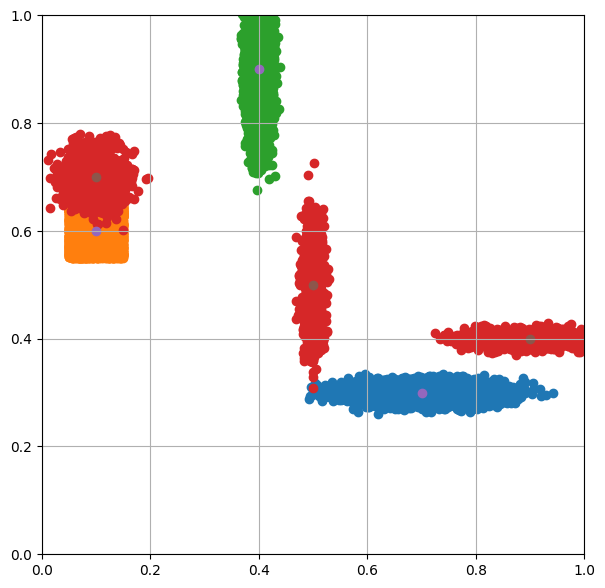

In [54]:
a1 = np.random.normal(loc=(0.7, 0.3), scale=(0.06, 0.01), size=(10000, 2))
a2 = np.random.normal(loc=(0.1, 0.6), scale=(0.06, 0.06), size=(100, 2))
a2 = np.random.uniform((0.1-0.05, 0.6-0.05),(0.1+0.05, 0.6+0.05), size=(10000, 2))
a3 = np.random.normal(loc=(0.4, 0.9), scale=(0.01, 0.06), size=(10000, 2))
am = AugmentationModel(torch.cat([torch.tensor(x) for x in [a1, a2, a3]], dim=0), n_clusters=3)
img = np.array([[0.1, 0.7], 
                [0.5, 0.5],
               [0.9, 0.4]])
labels = [1, 2, 2]
aug, labels = am(img, labels, 1000)
print(labels.shape)
print(aug.shape)
plt.figure(figsize=(7, 7))
plt.scatter(a1[:, 0], a1[: ,1])
plt.scatter(a2[:, 0], a2[: ,1])
plt.scatter(a3[:, 0], a3[: ,1])
plt.scatter(aug[:, 0], aug[: ,1])
plt.scatter(am.centroids[:, 0], am.centroids[: ,1])
plt.scatter(img[:, 0], img[:, 1])
plt.grid(True)
plt.ylim([0, 1])
plt.xlim([0, 1])

In [13]:
class CustomDataset(Dataset):
    
    def __init__(self, img_dir, transform=None, target_transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.labels = {}
        self.debug = False
        for f in tqdm(os.listdir(img_dir)):
            if os.path.isdir(os.path.join(img_dir, f)):
                DIR = os.path.join(img_dir, f)
                self.labels[f] = [os.path.join(DIR, name) for name in os.listdir(DIR) if os.path.isfile(os.path.join(DIR, name))]
    # def __init__(self, transform=None, target_transform=None, full_load=True):
    #     self.transform = transform
    #     self.target_transform = target_transform
    #     self.labels = {}
    #     self.debug = False

    def get_structure(self):
        count = 0
        structure = []
        for key in self.labels.keys():
            count += len(self.labels[key])
            structure.append(count)
        return structure
        
    def __len__(self):
        return sum([len(self.labels[label]) for label in self.labels.keys()])

    def __getitem__(self, idx):
        totensor = torchvision.transforms.ToTensor()
        if self.debug:
            print(idx)
        count = 0
        for key in self.labels.keys():
            if count + len(self.labels[key]) > idx:
                label = key
                break
            count += len(self.labels[key])
        image = totensor(Image.open(self.labels[label][idx - count])).to(DEVICE)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [14]:
preprocess = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [15]:
pretrain_dataset = CustomDataset("/kaggle/input/nct-crc-he-100k/NCT-CRC-HE-100K", transform=preprocess)

100%|██████████| 9/9 [04:59<00:00, 33.33s/it]


In [35]:
ds_path = Path("/kaggle/input/wss1-v1-psi/WSS1_v1_psi/train")
dataset = PsimageDataset(ds_path / "train_01.psi", ds_path / "train_01_anno.json", transform=preprocess)

100%|██████████| 31/31 [00:26<00:00,  1.18it/s]


In [43]:
train_dataloader = DataLoader(pretrain_dataset, batch_size=256, shuffle=True)
len(train_dataloader)

391

## Сравнение моделей

In [37]:
model1 = torchvision.models.resnet18(torchvision.models.ResNet18_Weights.IMAGENET1K_V1).to(DEVICE)
ReplaceFC(model1)
model2 = torchvision.models.resnet18(torchvision.models.ResNet18_Weights.IMAGENET1K_V1)
model2.load_state_dict(torch.load('/kaggle/input/utils-fs/clp.pth', weights_only=True)['state_dict'], strict=False)
ReplaceFC(model2)
accuracies1, accuracies2 = compare_models(FewShotModel(model1.to(DEVICE), LogisticRegression, max_iter=1000),
                                          FewShotModel(model2.to(DEVICE), LogisticRegression, max_iter=1000),
                                          dataset, 4, 5, 13, 100)
print(np.mean(accuracies1), np.mean(accuracies2))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
100%|██████████| 100/100 [03:56<00:00,  2.36s/it]

0.9247989660056751 0.9052899642669509


In [ ]:
base_dict = construct_dict(train_dataloader, model1)
augmentation = AugmentationModel(base_dict)
base_dict2 = construct_dict(train_dataloader, model2)
augmentation2 = AugmentationModel(base_dict2)

In [48]:
model1 = torchvision.models.resnet18(torchvision.models.ResNet18_Weights.IMAGENET1K_V1).to(DEVICE)
ReplaceFC(model1)
with torch.no_grad():
     accuracies1, accuracies2 = compare_models(FewShotModel(model1.to(DEVICE), LogisticRegression, augmentation, max_iter=1000),
                                          FewShotModel(model2.to(DEVICE), LogisticRegression, augmentation2, max_iter=1000),
                                          dataset, 4, 5, 13, 100)
print(np.mean(accuracies1), np.mean(accuracies2))

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
100%|██████████| 391/391 [07:48<00:00,  1.20s/it]
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
100%|██████████| 100/100 [19:57<00:00, 11.98s/it]

0.9258487390614828 0.9110177742269499


In [75]:
def memory_stats():
    print(torch.cuda.memory_summary())
    
def free_mem():
    torch.cuda.empty_cache()
    
# memory_stats()

del model
import gc
gc.collect()
torch.cuda.empty_cache()

## Pre-training

In [20]:
losses_history = {}

In [ ]:
# os.environ["WORLD_SIZE"] = "1"
# os.environ["MASTER_ADDR"]= "127.0.0.1"
# os.environ["MASTER_PORT"]= "6006"
# torch.distributed.init_process_group(rank=0)

In [ ]:
from sklearn.model_selection import ParameterGrid
param_grid = {'lr' : [1e-2], 'optimiser': [Lamb, torch.optim.Adam]}

for opt in ParameterGrid(param_grid):
    model = PretrainingModel(ResNet18Transfer).to(DEVICE)
    import gc
    gc.collect()
    torch.cuda.empty_cache()
    loss_history, acc_history = model.pre_train(
        train_dataloader,
        args_scheduler=[len(train_dataloader)],
        kwargs_scheduler={'eta_min': 1e-4},
        num_epoch=10,
        lr=opt['lr'],
        optimiser=opt['optimiser'],
    )
    losses_history[str(opt)] = loss_history
    torch.save(model.contrastive_model.base_encoder.state_dict(), f'model:{str(opt)}:{np.min(loss_history)}.pth')
    del model

In [ ]:
for opt, history in losses_history.items():
    plt.plot(history, label=opt)

plt.grid(True)
plt.legend()
plt.show()

In [ ]:
idx = np.random.randint(0, 64)
transforms = torchvision.transforms.Compose([
            torchvision.transforms.RandomResizedCrop(224, scale=(0.6, 1.0)),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.RandomVerticalFlip(),
            torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
        ])
y = transforms(x.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)
figure, axes = plt.subplots(1, 2)
axes[0].imshow(x[idx])
axes[1].imshow(y[idx])

[0.00125]


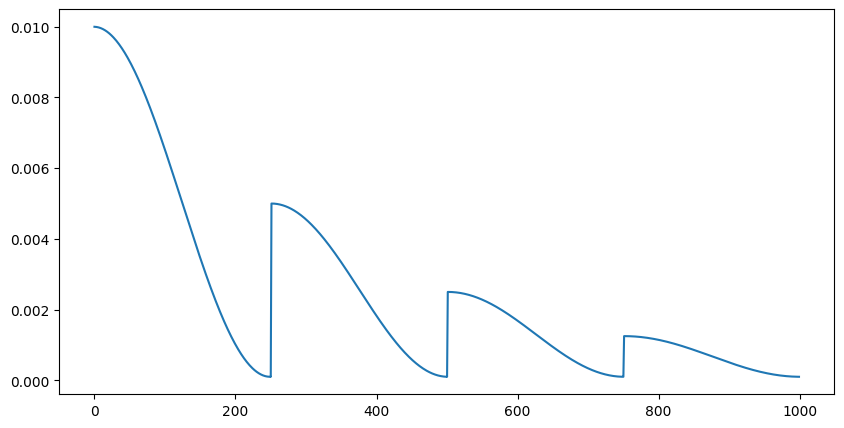

In [4]:
optimiser=torch.optim.AdamW
lr_scheduler=torch.optim.lr_scheduler.CosineAnnealingWarmRestarts
lr=1e-2
model = torch.nn.Linear(2, 3)
opt = optimiser(model.parameters(), lr=lr)
scheduler = lr_scheduler(opt, 250, eta_min=1e-4)
iter = []
lr = []
for i in range(1000):
    
    if i % 250 in [0, 249] and i != 0:
        scheduler.step(epoch=248)
        iter.append(i)
        lr.append(scheduler.get_last_lr())
    scheduler.step()
    iter.append(i)
    lr.append(scheduler.get_last_lr())
    if i % 250 == 0 and i != 0:
        scheduler.base_lrs[0] = scheduler.base_lrs[0] * 0.5
plt.figure(figsize=(10, 5))
plt.plot(iter, lr)
print(scheduler.base_lrs)
# plt.yscale('log')

In [ ]:
! zip m.zip model:18-7.pth
from IPython.display import FileLink
FileLink('m.zip')